In [11]:
import numpy as np
import numpy.ma as ma
import os
import h5py
from skimage import io
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd
import math
import time
import sys
import pickle
from visdom import Visdom

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from collections import defaultdict
from sklearn.metrics import f1_score
import cv2
import pandas as pd
import h5py

############### Visualization

from ipywidgets import Button, Layout
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display,clear_output,Video
from copy import copy
import numpy.ma as ma
import matplotlib.colors as colors
import imageio


sys.path.insert(0,'/media/DATA/jbonato/astro_segm/Astro3S/modules/')
from gen_single_astro  import filt_im
from sel_active_reg_gen import *
from model.dense_up import dense_up

from test_fun import gen_sc_mask,fix_mask,prob_calc,small_soma_to_proc,common_merge,art_rem_large,art_rem

from get_traces import update_dict_DNN
from gui_results import layout
from mask_roi_from_fiji import create_mask

# model to import
model = dense_up(3)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device1 = torch.device('cpu')#('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


###
MAX_ROI_AREA_PROC=30
MU_PX = 1
DOMAIN_RADIUS = 60
# motion corr in extracting traces
motion_corr=True

In [12]:
#PARAMS
N=512
M=512

fov_list = [2]
fov_DNN_weights_folder = '/media/DATA/jbonato/astro_segm/weights/dense_up' 
set_dir='/media/DATA/jbonato/astro_segm/set1/'

In [13]:
class SimDataset_test(Dataset):
    def __init__(self,image_set):
        self.input_images = image_set    


    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):        
        image = self.input_images[idx]
        image = torch.from_numpy(image).float()

        return image

    
vis_flag = False
##### LOAD PARAM DICT
with open(set_dir+'.tmp/dict_dataset1.txt', "rb") as fp:   #Pickling
    dict_param = pickle.load(fp)

dict_param

{'list': [0, 40, 80, 120, 160],
 'blocks': 15,
 'threads': 32,
 'BPM_ratio': 3,
 'bb': 96,
 'N_pix_st': 100,
 'astr_min': 80,
 'percentile': 80,
 'pad': 5,
 'astro_num': 4,
 'init_th_': 0.6,
 'decr_dim': 10,
 'decr_th': 25,
 'corr_int': False,
 'gpu_flag': True,
 'max_min': array([345,  89]),
 'th1_p': 0.25,
 'th2_p': 0.1}

In [14]:
dict_param['N_pix_st']=40
dict_param['astr_min']=20
dict_param['th1_p']=.2
dict_param['th2_p']=.05
dict_param['max_min']=np.asarray([345,30])
dict_param['astro_num']=40
dict_param['bb']=48
dict_param['pad']=0
dict_param['list']=[i*29 for i in range(17)]
dict_param['decr_dim'] = 5
dict_param['blocks'] = 15  
dict_param['threads'] =16  
max_min = dict_param['max_min']

In [15]:
stack_dir = '/media/DATA/jbonato/motion_corrected/TOMATO_14_Ch1__concatenate_corrected_aligned'
stack = io.imread(stack_dir + '.tiff').astype(np.uint16)[:750,:,:]
print(stack.shape)
# stack[:,220:,0:60]=0

# io.imsave(stack_dir + 'SupplementalMovie1_filt.tiff',stack)
dict_param

(750, 512, 512)


{'list': [0,
  29,
  58,
  87,
  116,
  145,
  174,
  203,
  232,
  261,
  290,
  319,
  348,
  377,
  406,
  435,
  464],
 'blocks': 15,
 'threads': 16,
 'BPM_ratio': 3,
 'bb': 48,
 'N_pix_st': 40,
 'astr_min': 20,
 'percentile': 80,
 'pad': 0,
 'astro_num': 40,
 'init_th_': 0.6,
 'decr_dim': 5,
 'decr_th': 25,
 'corr_int': False,
 'gpu_flag': True,
 'max_min': array([345,  30]),
 'th1_p': 0.2,
 'th2_p': 0.05}

In [16]:
# stack.shape
for i in range(20,40):
    print(i,472/i)

20 23.6
21 22.476190476190474
22 21.454545454545453
23 20.52173913043478
24 19.666666666666668
25 18.88
26 18.153846153846153
27 17.48148148148148
28 16.857142857142858
29 16.275862068965516
30 15.733333333333333
31 15.225806451612904
32 14.75
33 14.303030303030303
34 13.882352941176471
35 13.485714285714286
36 13.11111111111111
37 12.756756756756756
38 12.421052631578947
39 12.102564102564102


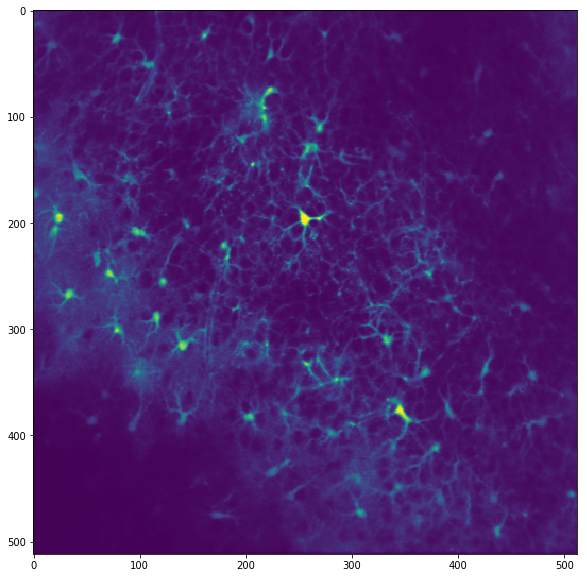

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(np.median(stack,axis=0))

In [18]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import cv2
from sklearn.externals.joblib import Parallel, delayed
from skimage.restoration import denoise_nl_means,estimate_sigma
from scipy import signal
from joblib import Parallel, delayed
import os
import h5py
from numba import cuda,float32,uint16,float64  

class ThScal():
    def __init__(self,stack):
        kernel = np.ones((50,50),np.float32)/(50*50)
        density = cv2.filter2D(np.median(stack,axis=0),-1,kernel)
        self.density = density/np.amax(density)
        
    def ThMat(self,ff,th_):
        N,M = ff.shape
        mask_th = th_*np.ones((N,M))
        
        cnt=1
        for i in [0.6,0.4,0.2,0]:
            buff = self.density.copy()
            buff[buff<i]=0
            buff[buff>=i+0.2]=0
            buff[buff>0]=1
            mask_th-=buff*(th_*0.05*cnt)
            cnt+=1

        ff[ff<mask_th]=0
        ff[ff>0]=1
        return ff

# @cuda.jit

# (bz,blocks_to_load[stps],mat_per_g,stack_gpu,im_out_g,cover_g,self.BPM_ratio,self.stp,self.iter_block)

# def sel_active_gpu(T,per_mat,stack,im_out,cover,BPM_ratio,stp,iter_block):
#     b_dimx = cuda.blockDim.x
#     b_dimy = cuda.blockDim.y
    
#     bx = cuda.blockIdx.x  
#     by = cuda.blockIdx.y
            
#     tx = cuda.threadIdx.x
#     ty = cuda.threadIdx.y

#     for bz in range(T):
#         if stack[bz,(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty] >= per_mat[bz,bx//BPM_ratio,by//BPM_ratio]:
#             cuda.atomic.add(im_out,(bz,(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty),1)
   
#         cuda.atomic.add(cover,(bz,(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty),1)
@cuda.jit#("void(int64,int64,float64[:,:,:],int32[:,:,:],int32[:,:],int32[:,:],int64,int64,int64)")#",int32,int32,int32)")
def sel_active_gpu(bz,time_ref,per_mat,stack,im_out,cover,BPM_ratio,stp,iter_block):
    #clean code 32 with step 5 with cycle 928 with step*cycle*iter-step
    size = cuda.gridDim.x
    cycle = size//3
    b_dimx = cuda.blockDim.x
    b_dimy = cuda.blockDim.y
    
    bx = cuda.blockIdx.x  
    by = cuda.blockIdx.y
            
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    for it_bk in range(1):
        for it_bk_y in range(1):
        
            if it_bk*32*5+((bx//BPM_ratio)*stp)<=928 and it_bk_y*32*5+((by//BPM_ratio)*stp)<=928:

                if stack[bz,it_bk*32*5+(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,it_bk_y*32*5+(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty] >= per_mat[bz+time_ref,it_bk*5+bx//BPM_ratio,it_bk_y*5+by//BPM_ratio]:
                    cuda.atomic.add(im_out,(it_bk*32*5+(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,it_bk_y*32*5+(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty),1)

                if bz ==0 and time_ref==0:
                    cuda.atomic.add(cover,(it_bk*32*5+(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,it_bk_y*32*5+(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty),1)

class sel_active_reg():
    
    def __init__(self,stack,dict_params,verbose=True,static=False):
        self.stack = stack
        self.step_list = dict_params['list']
        if len(self.step_list)==1:
            self.stp=1
        else:
            self.stp = self.step_list[1]-self.step_list[0]
        self.blocks = dict_params['blocks']
        self.threads = dict_params['threads']
        self.BPM_ratio = dict_params['BPM_ratio'] # # of block inside a patch
        self.bb = dict_params['bb']

        self.N_pix_st = dict_params['N_pix_st']
        self.astr_min = dict_params['astr_min']
        self.per_tile = dict_params['percentile']
        self.astro_num = dict_params['astro_num']
        self.init_th_ = dict_params['init_th_']
        self.decr_dim = dict_params['decr_dim']
        self.decr_th = dict_params['decr_th']
        self.corr_int = dict_params['corr_int']
        self.gpu_flag = dict_params['gpu_flag']
        self.static = static
        self.verbose = verbose
        self.iter_block = 5
        self.gpu_num = 0
        
    @staticmethod
    def percent_matrix_par(stack,t,listx,bb,per_tile):
        listy = listx
        dim = len(listx)
        matrix= t*np.ones((dim+1,dim),dtype=np.float32)

        for i in range(dim):
            for j in range(dim):

                x = listx[i] 
                y = listy[j]
                matrix[i,j] = np.percentile(stack[t,x:x+bb,y:y+bb],per_tile)  

        return matrix.astype(np.float32) 

    def sel_active_cpu(self):

        T,N,M = self.stack.shape
        T,N,M = stack.shape

        percent_list = Parallel(n_jobs=10,verbose=0)(delayed(self.percent_matrix_par) (self.stack,i,self.step_list,self.bb,self.per_tile) for i in range(T))
        percentiles = np.asarray(percent_list)
        mat_per = percentiles[:,:-1,:]
        mat_per = mat_per[percentiles[:,-1,0].astype(np.int32),:,:]

        im_out = np.empty((T,N,M)) 
        cover = np.zeros((T,N,M)) 
        for i in range(T):
            for x in self.listx:
                for y in self.listy:

                    buffer_im = self.stack[i,x:x+self.bb,y:y+self.bb]-mat_per[i,x//self.stp,y//self.stp]
                    buffer_im[buffer_im<0]=0.
                    buffer_im[buffer_im>0]=1.

                    im_out[i,x:x+self.bb,y:y+self.bb]+=buffer_im
                    cover[i,x:x+self.bb,y:y+self.bb]+=1


        
        self.mask_tot = np.empty_like(im_out)
        self.mask_tot  = im_out/cover 
    
    def sel_active_reg_gpu(self):

        T,N,M = self.stack.shape
        cuda.select_device(self.gpu_num)    

        threadsperblock = (self.threads,self.threads)
        blockspergrid = (self.blocks,self.blocks)
            
        if self.verbose: print('Computing local thresholds')
        # compute percentile in patches
        if not(self.static):
            percent_list = Parallel(n_jobs=-1)(delayed(self.percent_matrix_par) (self.stack,i,self.step_list,self.bb,self.per_tile) for i in range(T))
            percentiles = np.asarray(percent_list).astype(np.float32)
            mat_per = percentiles[:,:-1,:]

            mat_per = mat_per[percentiles[:,-1,0].astype(np.int32),:,:]# reorder the embarasing parallel collection of mat
            
        #### mod for static fluorophore
        # compute a single percentile for all the stack, and than generate a T x num_patch x num_patch 
        elif self.static:
            mat_per = np.percentile(self.stack.flatten(),self.per_tile).reshape(1,1)
            mat_per = np.tile(mat_per,(T,1,1))
            
            
        #mat_per = np.zeros((T,len(self.step_list),len(self.step_list)))#,dtype=np.int32   
        ### allocate percentile matrix
        if self.verbose: print('GPU started',blockspergrid, threadsperblock)
        mat_per_g = cuda.to_device(mat_per) 
        ### allocate in ram
        im_out = np.zeros((N,M),dtype=np.int32)
        cover = np.zeros((N,M),dtype=np.int32)
        ### allocate and load in DRAM
        im_out_g = cuda.to_device(im_out)
        cover_g = cuda.to_device(cover)
        #iter_block_gpu = cuda.to_device(self.iter_block)
        blocks_to_load =[i*200 for i in range((T//200)+1)]
        blocks_to_load.append(T)
       
        for stps in range(len(blocks_to_load)-1):
            stack_gpu = cuda.to_device(self.stack[blocks_to_load[stps]:blocks_to_load[stps+1],:,:])
            for bz in range(blocks_to_load[stps+1]-blocks_to_load[stps]):
                sel_active_gpu[blockspergrid, threadsperblock](bz,blocks_to_load[stps],mat_per_g,stack_gpu,im_out_g,cover_g,self.BPM_ratio,self.stp,self.iter_block)
            ### free from old stack
            del stack_gpu

        im_out = im_out_g.copy_to_host()
        cover = cover_g.copy_to_host()
        if self.verbose: print('GPU done')
        del im_out_g, cover_g, mat_per_g
        
        self.mask_tot = np.empty_like(im_out).astype(np.float64)
        self.mask_tot  = im_out.astype(np.float64)/cover.astype(np.float64) 
        return im_out,cover 
          
    def get_mask(self,find_round=True):
        T,_,_ = self.stack.shape
        
        if self.gpu_flag:
            self.sel_active_reg_gpu()
        else:
            self.sel_active_reg_cpu()
    
        if self.corr_int:
            scaling = ThScal(self.stack)

       
        th_ =round(T*self.init_th_)
        
        if find_round:
            #this is an alternative strategy to select the strating point threshold the nearest to th_, it is a seed for the while below 
            #this strategy can be removed and th_ will be the T*self.init_th_ and not one of the seed points below
            # we used this strategy for dataset-1, this approach reduces large variation in th_ due to small variation in self.init_th_
            if T>500: 
                th_list = [200,250,300,350,400,450,500,550,600,650,700]
                th_list = np.asarray(th_list)
                th_ref =th_list-th_
                th_ = th_list[np.argmin(np.abs(th_ref))]
        cnt=0
        #print(th_)
        starting_th = th_
        flag_th=True
        N_pix = self.N_pix_st
        
        while(cnt<self.astro_num and N_pix>=self.N_pix_st*0.3 and th_>round(T*0.3)):
            if flag_th:
                mask_tot_s = np.sum(self.mask_tot,axis=0)

                if self.corr_int:
                    mask_tot_s = scaling.ThMat(mask_tot_s,th_)
                    mask_tot_s= np.uint8(mask_tot_s)
                else:
                    mask_tot_s[mask_tot_s<=th_]=0
                    mask_tot_s[mask_tot_s>0.5]=255
                    mask_tot_s= np.uint8(mask_tot_s)  


                ret, labels_r = cv2.connectedComponents(mask_tot_s)
                flag_th = False

            labels = labels_r.copy()
            cnt=0
            for i in range(1, ret):
                pts =  np.where(labels == i)    

                if len(pts[0]) < N_pix:

                    labels[pts] = 0
                else:
                    cnt+=1

                    labels[pts] = 255         

            N_pix-=self.decr_dim
            if N_pix<=self.astr_min and (starting_th-th_)<105:

                th_-=self.decr_th
                flag_th = True  
                N_pix=self.N_pix_st


        if self.verbose:
            print('Zones',cnt)
        # clean eventual artifacts
        ret, labels = cv2.connectedComponents(np.uint8(labels))
        for i in range(1, ret):
            pts =  np.where(labels == i)    
            if len(pts[0])<self.astr_min//4:
                labels[pts]=0
        labels[labels>0]=1
        return labels

In [22]:
dict_im = {}
dict_im['Astro_domain_radius'] = DOMAIN_RADIUS
for jj in fov_list:
    #im_list = []
    Res_1 = np.zeros((N,M,3))

    test_folder_str =str(jj)
    if len(test_folder_str)==1:
        test_folder_str1='00'+test_folder_str
    else:
        test_folder_str1='0'+test_folder_str

    model.load_state_dict(torch.load(fov_DNN_weights_folder+test_folder_str1+'D1.pt'))
    
    #collect stack to analyze
    
    stack = io.imread('/media/DATA/jbonato/motion_corrected/TOMATO_14_Ch1__concatenate_corrected_aligned.tiff').astype(np.uint16)[:750,:,:]
    print(stack.shape)
    #stack[:,220:,0:60]=0

    dict_im['t-series_'+test_folder_str1] = stack
    frames,_,_ = stack.shape

    a_reg = sel_active_reg(stack.astype(np.float32),dict_param)
    A,B = a_reg.sel_active_reg_gpu()
    #mask = a_reg.get_mask()
    #mask = fix_mask(mask)
    
#     #im_list.append([mask,'Active Regions'])
#     dict_im['Active Regions_'+test_folder_str1] = mask
    
#     filter_ = filt_im('/media/DATA/jbonato/tdTomato/td_06_Ch1__concatenate_corrected_aligned.tiff',mask,dict_param['bb']-2*dict_param['pad'])
#     _, image_to_plot = filter_.create_img()
#     # for other dataset spatia_pp methods can be called from filter_, outputs are stack filtered and spatial map enhanced  
#     #im_list.append([image_to_plot,'Enhanced'])
#     dict_im['Enhanced_'+test_folder_str1] = image_to_plot
#     coord_l = filter_.get_instances()
    
#     assert coord_l!=0, 'Check Active region extraction module'
    
    
#     image_stack = np.empty((len(coord_l),dict_param['bb'],dict_param['bb'])) 

#     image_stack,filt_imageL = filter_.save_im()#select the padding val 5 is default
    
    
#     image_set = image_stack[:,0,:,:]
#     image_set = image_set[:,np.newaxis,:,:]

#     imageL_set = image_to_plot*filt_imageL
#     imageL_set-=np.mean(imageL_set)
#     imageL_set= imageL_set[np.newaxis,np.newaxis,:,:]



#     model.eval()   # Set model to evaluate mode
#     ######################################## Prob Map
#     test_datasetL = SimDataset_test(imageL_set)
#     test_loader = DataLoader(test_datasetL, batch_size=15, shuffle=False, num_workers=0)

#     inputs = next(iter(test_loader))
#     inputs = inputs.to(device)
#     pred = model(inputs)
    
#     pred_mean = pred.data.cpu().numpy()
#     del test_datasetL,test_loader, inputs,pred
    
#     mean = pred_mean[0]
#     maxim = np.amax(mean,axis=0)
#     mean[mean<maxim]=0
        
#     prob_mapPL,sm_ent = prob_calc(mean[1,:,:],max_min[0],max_min[1])
    
#     #im_list.append([prob_mapPL,'Prob. Map'])
#     dict_im['Prob. Map PL_'+test_folder_str1] = prob_mapPL
#     #im_list.append([sm_ent,'Prob. Map'])
#     dict_im['Prob. Map_'+test_folder_str1] = sm_ent
#     ########################################## putative single cell
#     test_dataset_S = SimDataset_test(image_set)
#     test_loader = DataLoader(test_dataset_S, batch_size=15, shuffle=False, num_workers=0)

    
#     pred_mean=[]
#     for inputs in test_loader:
#         inputs = inputs.to(device)

#         pred = model(inputs)
#         pred_mean.append(pred.data.cpu().numpy())
#         del inputs,pred

#     torch.cuda.empty_cache()
    
#     for j in range(1,len(pred_mean)):
#         pred_mean[0]=np.vstack((pred_mean[0],pred_mean[j]))

#     prob_map = np.zeros((N,M,2))

#     for i in range(len(coord_l)):
#         mean= np.zeros((3,dict_param['bb'],dict_param['bb']))
#         mean = pred_mean[0][i,:,:,:].copy()
        
#         maxim = np.amax(mean,axis=0)
#         mean[mean<maxim]=0
#         mean[mean>=maxim]=1

#         small_soma = small_soma_to_proc(mean[1,:,:],N = int((2/3)*max_min[1])) ####remove too small somata segmentated
#         mean[0,:,:]+=small_soma
#         mean[1,:,:]-=small_soma
        
#         coord = coord_l[i]
#         Res_1[coord[1]:coord[3],coord[0]:coord[2],0] += mean[0,dict_param['pad']:-dict_param['pad'],dict_param['pad']:-dict_param['pad']]
#         Res_1[coord[1]:coord[3],coord[0]:coord[2],1] += mean[1,dict_param['pad']:-dict_param['pad'],dict_param['pad']:-dict_param['pad']]



#     Res_1[:,:,0] -= Res_1[:,:,1]
#     Res_1[Res_1<1]=0
#     Res_1[Res_1>0]=1

#     ######### can be wrapped
    
#     soma_f = common_merge(Res_1[:,:,1],sm_ent)
#     Res_1[:,:,1]=soma_f

#     #remove possible artifacts
#     small_soma = small_soma_to_proc(Res_1[:,:,1],int(0.9*max_min[1]),dilation=False)
#     Res_1[:,:,1]-=small_soma

#     Res_1[:,:,0] = Res_1[:,:,0]-Res_1[:,:,1]
#     Res_1[Res_1<1]=0
#     Res_1[Res_1>0]=1

#     #remove large region classified as soma Area>500
#     Res_1_filt,removal = art_rem_large(Res_1[:,:,1],Res_1[:,:,0],N=int(1.15*max_min[0]))
#     if removal<2:
#         Res_1-=Res_1_filt[:,:,np.newaxis]

#     Res_1_filt,removal = art_rem_large(Res_1[:,:,1],Res_1[:,:,0],N=max_min[0])
#     if removal<2:
#         Res_1-=Res_1_filt[:,:,np.newaxis]


#     #remove processes without soma
#     Res_1_filt = art_rem(Res_1[:,:,1],Res_1[:,:,0])
#     Res_1*=Res_1_filt[:,:,np.newaxis]
    
#     dict_im['Final_Mask_'+test_folder_str1] = Res_1
#     print(20*'%')
#     #######################################################################################################
#     #Visualization of images
#     if vis_flag:
#         vis = Visdom(port=8097, server="http://localhost",env='inference_plot')
#         for key in dict_im.keys():
#             if key in ['Active Regions_'+test_folder_str1,'Enhanced_'+test_folder_str1,'Final_Mask_'+test_folder_str1]:
#                 image = dict_im[key]
#                 fig, ax = plt.subplots(figsize=(4,4))
#                 ax.imshow(image)
#                 ax.axis('off')
#                 ax.set_title(key)
#                 vis.matplot(fig)
#                 plt.close(fig)
    
#     #### Extraction
#     single_astro_roi = gen_sc_mask(dict_im['Final_Mask_'+test_folder_str1])


(750, 512, 512)


CudaSupportError: Error at driver init: 
[803] Call to cuInit results in UNKNOWN_CUDA_ERROR:

In [ ]:
plt.imshow(B)

In [ ]:
plt.imshow(dict_im['Active Regions_'+test_folder_str1])

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(dict_im['Enhanced_'+test_folder_str1])

In [ ]:
plt.imshow(dict_im['Final_Mask_'+test_folder_str1])

# Visualization of results

In [5]:
fov_name = []
for j in fov_list:
    j = str(j)
    if len(j)==1:
        j='00'+j
    else:
        j='0'+j
    fov_name.append(j)
fov_name
hbox,button,display_plot = layout(fov_name,dict_im)
display(hbox)
button.on_click(display_plot)

# Manual curation
Export ROIs for ImageJ

In [6]:
from ROI_manual_curation import *

In [7]:
#export ROIs for ImageJ
export_roi(dict_im,fov_list,N=256,M=256,folder_save = '/media/DATA/jbonato/astro_segm/notebook/')

FOV 002


In [8]:
#clean dictionary from ROIs and extracted traces
dict_im = clean_dict(dict_im,fov_list)

In [9]:
#update dict_im with the manual curated
for fov in fov_list:
    folder = f'{str(fov):0>3}'
    mask_ret = read_roi_curated(folder,N=256,M=256,folder_read='/media/DATA/jbonato/astro_segm/notebook/')
    dict_im = update_dict_DNN(dict_im,mask_ret,folder,motion_corr,MAX_ROI_AREA_PROC,MU_PX)
    #### save dict
    pickle.dump(dict_im, open( "inference_ex.pkl", "wb" ) )

NUM ROI 5
ROI NUM 5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 0
ROIS 4
SPLIT DONE (256, 256, 10)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 1
ROIS 1
SPLIT DONE (256, 256, 24)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 2
ROIS 4
SPLIT DONE (256, 256, 10)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 3
ROIS 3
SPLIT DONE (256, 256, 11)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 4
ROIS 4
SPLIT DONE (256, 256, 9)
Extraction: done


In [39]:
from __future__ import division
from numba import cuda
import numpy
import math
        


# CUDA kernel
@cuda.jit
def my_kernel(io_array):
    pos = cuda.grid(1)
    if pos < io_array.size:
        io_array[pos] *= 2 # do the computation

# Host code   
data = numpy.ones(256)
threadsperblock = 256
blockspergrid = math.ceil(data.shape[0] / threadsperblock)
my_kernel[blockspergrid, threadsperblock](data)
print(data)

NvvmError: Failed to compile

<unnamed> (38, 31): parse expected comma after getelementptr's type
NVVM_ERROR_COMPILATION